# Creating an image retrieval engine from a pre-trained neural network

Here we show how to create a simple image retrieval engine that uses **transfer learning** to represent images using features extracted from a network trained for a different task.

This demo will use the [Oxford buildings dataset](http://www.robots.ox.ac.uk/~vgg/data/oxbuildings/). This is not one of the PyTorch built-in datasets, so we'll need to download it and create a custom dataset class.

The task is to build an image similarity search engine (often called reverse-image search). Given an query image, rank images in the dataset by similarity and return the top ranked results.

Other popular datasets for image retriveal are:
- Paris buildings
- INSTRE
- TRECVid


In [ ]:
device = 'cuda'

# Download the Oxford 5K buildings dataset

The [Oxford Buildings Dataset](http://www.robots.ox.ac.uk/~vgg/data/oxbuildings/) is a widely used retrieval dataset from the VGG group at the University of Oxford. 

- Consists of 5063 images collected from Flickr by searching for particular Oxford landmarks. 
- Manually annotated to generate a comprehensive ground truth for 11 different landmarks, each represented by 5 possible queries. 
- Gives a set of 55 queries over which a retrieval system can be evaluated. 

In [ ]:
!mkdir -p data/oxford/gt

In [ ]:
!curl https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz >> data/oxford/oxbuild_images.tgz
!curl https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/gt_files_170407.tgz >> data/oxford/gt/files.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   276  100   276    0     0   5520      0 --:--:-- --:--:-- --:--:--  5411
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   277  100   277    0     0  11080      0 --:--:-- --:--:-- --:--:-- 11080


Extract the images

In [ ]:
cat data/oxford/oxbuild_images.tgz

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>301 Moved Permanently</title>
</head><body>
<h1>Moved Permanently</h1>
<p>The document has moved <a href="https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz">here</a>.</p>
</body></html>


In [ ]:
!cd data/oxford && tar xf oxbuild_images.tgz && rm oxbuild_images.tgz 

Extract the ground truth

In [ ]:
!cd data/oxford/gt && tar xf files.tgz && rm files.tgz 

Check how many images we have

In [ ]:
!ls data/oxford/*.jpg | wc -l

5063


# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.utils import make_grid
from torchvision.models import resnet50
from pathlib import Path


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a dataset class for Oxford5k

Since Oxford5K is not a built in dataset, we'll need to create a simple dataset class for it. This is a common pattern in PyTorch. To create a dataset class, you simply need to implement the `__getitem__` and `__len__` methods.

In [ ]:
class Oxford5k(Dataset):
    def __init__(self, root='data/oxford', transform=None, loader=pil_loader):
        self.root = Path(root)

        # search in root for files with a jpeg extension
        self.filenames = list_files(self.root, '.jpg', prefix=False)
        self.filenames.sort()
        self.loader = loader
        self.transform = transform
        
    def __getitem__(self, index):
        # get path to file
        filename = self.root / self.filenames[index]

        # load image
        image = self.loader(filename)

        # apply transform if we have one
        if self.transform is not None:
            image = self.transform(image)

        # return the image
        return image
        
    def __len__(self):
        return len(self.filenames)


Test dataset class to make sure everything is working OK

Number of images 5063


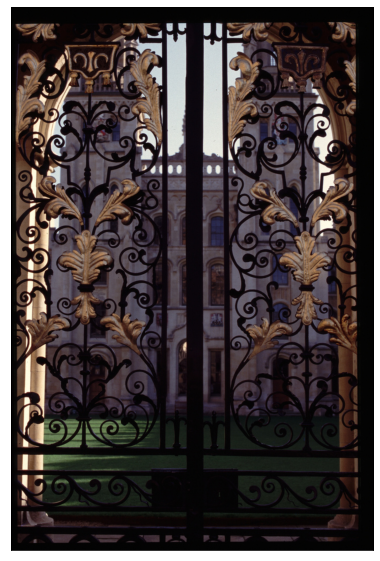

In [ ]:
dataset = Oxford5k()
print('Number of images', len(dataset))
plt.figure(figsize=(8, 10))
plt.imshow(dataset[0])
plt.xticks([]); plt.yticks([]); plt.grid(False)

## Instantiate a dataset with appropriate data transforms for ResNet

Add some transforms to make the images the same size and have the same normalization as was used when the network was originally trained.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = Oxford5k(transform=transform)
print(dataset[0].shape)

torch.Size([3, 224, 224])


## Create a loader to process the dataset

In [ ]:
loader = DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False)

# Load a pre-trained ResNet 50 model

We're going to use a ResNet-50 as a feature extractor. You can also try out a different model here if you like.

In [ ]:
net = resnet50(pretrained=True)
net.fc = nn.Sequential()
net.layer4[2].relu = nn.Sequential()
net.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Let's visualize the weights in the first layer to see if the model really is pretrained!

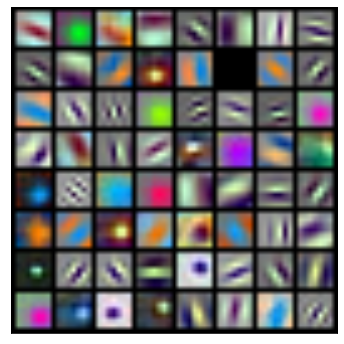

In [ ]:
with torch.no_grad():
    W = net._modules.get('conv1').weight.cpu()

    grid = make_grid(W, 8, padding=1, normalize=True, scale_each=True).numpy()
    grid = grid.transpose(1, 2, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(grid, interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

# Tuning the batch norm

Here we're going to apply a rudimentaty **domain adaptation** trick. The batch norm statistics for this network match those of the ImageNet dataset. We can use a trick to get them to match our dataset. The idea is to put the network into train mode and do a pass over the dataset **without doing any backpropagation**. This will cause the network to update the batch norm statistics for the model without modifying the weights. This can sometimes improve results.

In [ ]:
net.train()
n_batches = len(loader)
for i, batch in enumerate(loader):
    # move batch to device and forward pass through network
    net(batch.to(device))
    print(f'\rTuning batch norm statistics {i+1}/{n_batches}', end='', flush=True)
net.eval();

Tuning batch norm statistics 317/317

# Extract features for the full dataset

Features are extracted from the average pooling layer before the classification layer at the end of resnet. These are 2048 D vectors that can be used to represent the image. Distances in this representation space tend to be more meaningful than distances in pixel space.



In [ ]:
# It is very important to put the network into eval mode before extracting features! This 
# turns off things like dropout and using batch statistics in batch norm. 

net.eval();

# What happens if you don't do this with ResNet50? The features you get depend on the order
# of the examples! Why? Because the batch norm statistics are estimated from the batch instead
# of using the running statistics from the training set.


Extract the features

In [ ]:
features = []
n_batches = len(loader)

with torch.no_grad():
    for i, batch in enumerate(loader):

        # move batch to device
        batch = batch.to(device)

        # forward pass through the network to get the features
        batch_features = net(batch)

        # features to numpy
        batch_features = torch.squeeze(batch_features).cpu().numpy()

        # collect features
        features.append(batch_features)
        print(f'\rProcessed {i+1} of {n_batches} batches', end='', flush=True)

# stack the features into a N x D matrix
features = np.vstack(features)

print(f'\nFeatures are {features.shape}')

Processed 317 of 317 batches
Features are (5063, 2048)


# Postprocessing

A standard postprocessing pipeline used in retrieval applications is to do L2-normalization, PCA whitening, and L2-normalization again. Effectively this  decorrelates the features and makes them unit vectors. 

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [ ]:
features = normalize(features, norm='l2')
features = PCA(512, whiten=True).fit_transform(features)
features = normalize(features, norm='l2')

In [ ]:
print(features.shape)

(5063, 512)


# Querying the data

First create a version of the dataset without `ToTensor` and `Normalize` so that  we can show images with `imshow`

In [ ]:
visual_dataset = Oxford5k(
    transform=transforms.Compose([transforms.Resize(255), transforms.CenterCrop(255)]))

Now, specify which image to use as the query and show the corresponding image from the dataset.

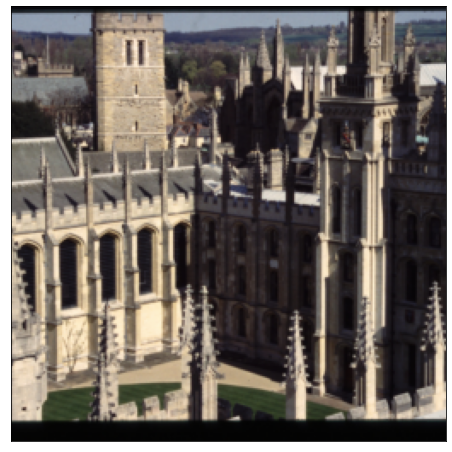

In [ ]:
# change this to the index of the image to use as a query!
query_idx = 1

# show the image
plt.figure(figsize=(8, 8))
plt.imshow(visual_dataset[query_idx])
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

# Scoring and ranking

We will search using cosine similarity. This gives the same rankings as (negative) Euclidean distance when the features are L2 normalized (as ours are).

The cosine similarity can be efficiently computed for all images in the dataset using a matrix multiplication!

In [ ]:
# searching can be done using cosine similarity
# since the features are normalized, this is just a matrix multiplication

query = features[query_idx]
scores = features @ query # Xq
print(scores.shape)

(5063,)


By sorting the scores (or actally the indexes by score), you can rank the images by similarity. 

We use numpy's `argsort` for this. `argsort` sorts ascending (from lowest to highest), which is the opposite of what we want. This can easily be remedied by sorting the negative of the score. 

In [ ]:
# rank by score, descending, and skip the top match (because it will be the query)
ranking = (-scores).argsort()[1:]

# Show some results

Show the top-10 ranked images and also the bottom-10 ranked ones. The top-10 should be more similar to the query than the bottom!


Query


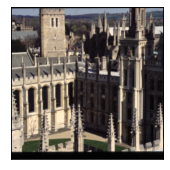

Top 10


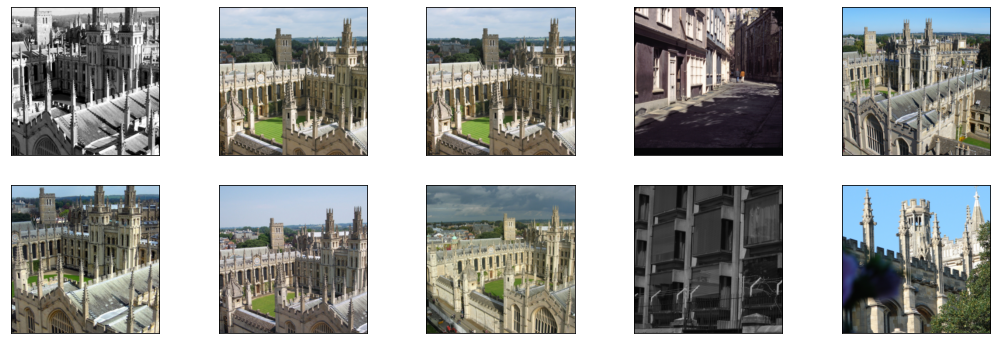

In [ ]:
# show the query image
print('Query')
plt.figure(figsize=(2.8,2.8))
plt.imshow(visual_dataset[query_idx])
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

print('Top 10')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
ax = ax.ravel()
for i in range(10):
    image = visual_dataset[ranking[i]]

    # show the image (remove ticks and grid)
    ax[i].imshow(image)
    ax[i].grid(False) 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

Bottom 10


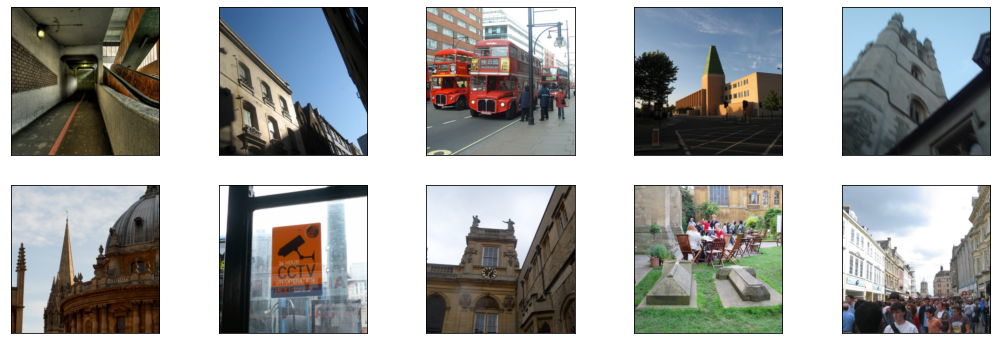

In [ ]:
print('Bottom 10')
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(18, 6))
ax = ax.ravel()
for i in range(10):
    image = visual_dataset[ranking[-(i+1)]]

    # show the image (remove ticks and grid)
    ax[i].imshow(image)
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

#Evaluation

Let's formally evaluate the system using the ground truth to see how well we are doing.

## Load ground truth

The following code is needed to parse the ground truth from the Oxford5K dataset. This is very dataset specific, so no need to worry about it.

In [ ]:
def load_ground_truth_entries(path='data/oxford/gt'):
    filenames = list_files(path, '.txt', prefix=False)
    filenames.sort()
    entries = {}
    for fn in filenames:
        ident, kind = fn.rsplit('_', 1)
        entry = entries.setdefault(ident, {'query': '', 'gt': [], 'box': None})
        fullpath = os.path.join(path, fn)
        
        with open(fullpath, 'r') as f:
            lines = [l.strip() for l in f if len(l.strip())]
        
        if kind.startswith('query'):
            parts = lines[0].split(' ')
            entry['query'] = parts[0].split('_', 1)[1]
            entry['box'] = list(map(float, parts[1:]))
        
        elif kind.startswith('good') or kind.startswith('ok'):
            entry['gt'].extend(lines)
    return entries


def make_ground_truth_matrix(filenames, entries):
    n_queries = len(entries)
    q_indx = np.zeros(shape=(n_queries, ), dtype=np.int32)
    y_true = np.zeros(shape=(n_queries, 5063), dtype=np.uint8)

    for i, q in enumerate(entries):
        entry = entries[q]
        filename = entry['query'] + '.jpg'
     
        # lookup query index
        q_indx[i] = filenames.index(filename)

        # lookup gt filenames
        gt_filenames = entry['gt']
        gt_filenames = [f + '.jpg' for f in gt_filenames]

        # lookup gt indices
        gt_indices = [filenames.index(f) for f in gt_filenames]
        gt_indices.sort()

        y_true[i][q_indx[i]] = 1
        y_true[i][gt_indices] = 1

    return q_indx, y_true

queries = load_ground_truth_entries()
q_indx, y_true = make_ground_truth_matrix(dataset.filenames, queries)

## Run evaluation

The first thing we are going to do compute the cosine similarity of every image with every other image. In reality, we only need the similarity between the query images and every other, but since this is a small dataset, it's just as easy to run image against every other. This will produce a similarity matrix $S$ which will be useful later for diffusion.

If $X \in \mathbb{R}^{N\times D}$ is a matrix of our $N$ image times $D$ dimensional features, then $S$ can be computed as: $$S = X X^T \in \mathbb{R}^{N\times N}.$$:

In [ ]:
S = features @ features.T
print(S.shape)

(5063, 5063)


Retrieval systems are often evaluated using a metric known as **mean average precision**, or mAP. To compute mAP we first compute individual average precision (AP) scores for a set of queries, and then compute the average of these averages to give mAP.

The code below collects the AP scores for each query from the similarity matrix and the ground truth

In [ ]:
from sklearn.metrics import average_precision_score

def evaluate(S, y_true, q_indx):
    aps = []
    for i, q in enumerate(q_indx):
        s = S[:, q]
        y_t = y_true[i]
        ap = average_precision_score(y_t, s)
        aps.append(ap)
    df = pd.DataFrame({'ap': aps}, index=q_indx)
    return df

And then we compute the mAP

In [ ]:
df = evaluate(S, y_true, q_indx)
print(f'mAP: {df.ap.mean():0.04f}')

mAP: 0.5420


This is pretty good, considering we just used an off the shelf network as a feature extractor. We are also not using the provided bounding boxes when issuing the query.

# Improving the results

There are ways to improve the results:
- Test time data augmentation 
- Use pooled features from the convolutional layer (depends on net architecture)
- Query expansion
- Graph diffusion (e.g. [this CVPR 2017 paper](https://arxiv.org/abs/1611.05113))
- [Bags of local convolutional features](https://imatge.upc.edu/web/publications/bags-local-convolutional-features-scalable-instance-search)
- Center bias, [saliency weighting](https://github.com/imatge-upc/salbow)
- Regional features (e.g. [RMAC](https://arxiv.org/pdf/1604.01325.pdf))
- Fine tuning the network using triplet loss on [landmarks](https://www.kaggle.com/google/google-landmarks-dataset)

Image retrieval is an active research area!

## Average query expansion (AQE)

Let's try out average query expansion to see if it improves results. AQE is cheap, and usually helps, so it's usually a good idea to do this.

In [ ]:
def average_query_expansion(features, q_indx, k=5):
    new_features = features.copy()
    for index in q_indx:
        query = features[index]
        scores = features @ query
        ranking = (-scores).argsort()
        indices = ranking[:k+1]
        new_features[index] = features[indices].mean(axis=0)
    return new_features

In [ ]:
# do query expansion to update features for the queries to be equal to the 
# average of the top-K ranked results (including the query itself)
features = average_query_expansion(features, q_indx, 5)

# compute the new similarity matrix
S_aqe = features @ features.T

# compute mAP
df = evaluate(S_aqe, y_true, q_indx)
mAP_aqe = float(df.mean())
print(f'mAP: {mAP_aqe:0.4f}')

mAP: 0.6460


## Diffusion

One way to improve the results is to use a technique known as diffusion. The code below shows how to do diffusion on the Oxford dataset. The basic idea behind diffusion is to construct a k-nearest neighbour graph and then measure how likely a random walker is to land on a particular image if starting at the query image. If the graph is carefully constructed, this can give improvements to the final ranking.

As implemented here, it would be too expensive for larger datasets, but there are methods of making it faster using approximate nearest neighbour graphs (e.g. https://github.com/facebookresearch/faiss).

In [ ]:
import scipy.sparse as sparse

def normalize_columns(S):
    totals = S.sum(axis=1)
    totals[totals == 0] = 1
    return S / totals[:, np.newaxis]


def knn_matrix(S, k, threshold=0.0, fill=-1000):
    """
    Threshold S to keep top k entries and fill the rest with the given value.
    Returns update S (does not modify S)
    """
    S = S.copy()

    # figure out the k-th order statistic by partition
    thresholds = (-np.partition(-S, k, axis=1))[:, k]

    # clip thresholds
    if threshold is not None:
        thresholds[thresholds < threshold] = threshold

    # zero out everything below the threshold
    S[S < thresholds[np.newaxis, :]] = fill

    return S


def diffuse(S, q_indx, gamma=20.0, t=0.05, k=50, alpha=0.999, iters=300):

    # compute KNN matrix
    A = knn_matrix(S, k, t)

    # convert similarities to "affinities"
    A = np.exp(gamma * (A - 1))

    # take initial y from the knn graph affinities
    y = A[:, q_indx]

    # clear diagonal to remove transitions to self
    np.fill_diagonal(A, 0)

    # make stochastic matrix T
    T = normalize_columns(A)

    # convert to CSR format
    T = sparse.csr_matrix(T)

    # report stats
    percent_filled = (T.nnz * 100.)/(T.shape[0] * T.shape[1])
    print('nnz: {}  sparsity: {:.03f}%'.format(
        T.nnz, 100-percent_filled), end='  ')
    print('average neighbours: {:.1f}'.format(T.nnz / T.shape[1]))

    # graph diffusion: this is essentially personalized pagerank. i.e.
    # power iteration to find principal eigenvector with y mixing
    p = y
    for i in range(iters):
        p = alpha * T @ p + (1 - alpha) * y

    # A = p
    A[:, q_indx] = p
    np.fill_diagonal(A, 1)
    return A

In [ ]:
A = diffuse(S, q_indx)

nnz: 253150  sparsity: 99.012%  average neighbours: 50.0


In [ ]:
df = evaluate(A, y_true, q_indx)
mAP_diffusion = float(df.mean())
print(f'mAP: {mAP_diffusion:0.4f}')

mAP: 0.7169
